<a href="https://colab.research.google.com/github/KushGabani/Lab-Assignments/blob/main/Script_Generation_using_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import io
import os
import sys
import warnings
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
 
try:
  shutil.rmtree("./sample_data")
except:
  pass

In [ ]:
with io.open("./drive/MyDrive/moes_tavern_lines.txt", encoding = "utf-8-sig") as f:
  text = f.read().lower()

print("Sample training data :\n")
text = text[81:]
print(text[:500])

Sample training data :

moe_szyslak: (into phone) moe's tavern. where the elite meet to drink.
bart_simpson: eh, yeah, hello, is mike there? last name, rotch.
moe_szyslak: (into phone) hold on, i'll check. (to barflies) mike rotch. mike rotch. hey, has anybody seen mike rotch, lately?
moe_szyslak: (into phone) listen you little puke. one of these days i'm gonna catch you, and i'm gonna carve my name on your back with an ice pick.
moe_szyslak: what's the matter homer? you're not your normal effervescent self.
homer_simp


In [ ]:
data = text.split("\n")
print(data[0])
data = " ".join(data)
print(data[:100])

moe_szyslak: (into phone) moe's tavern. where the elite meet to drink.
moe_szyslak: (into phone) moe's tavern. where the elite meet to drink. bart_simpson: eh, yeah, hello


In [ ]:
len(data)

305189

In [ ]:
punctuations = {
    '.' : "period", 
    '[' : "leftbraces",
    ']' : "rightbraces",
    '(' : "leftparen",
    ')' : "rightparen",
    ';' : "semicolon",
    '$' : "price",
    '%' : "percentage",
    '&' : "and",
    '#' : "hash",
    '\n' : "newline",
    ':' : "colon", 
    "'" : "apostrophe",
    '/' : "or",
    '"' : "quote",
    ',' : "comma",
    '?' : "question",
    '*' : "asterisk",
    '!' : "exclamation",
    '-' : "hyphen",
}

def preprocess_text(text):
  for punc, alt in punctuations.items():
    text = text.replace(punc, ' ' + alt + ' ')
  text = text.replace("\n", punctuations["\n"])
  tokens = text.split()
  return tokens

tokens = preprocess_text(text)
print(tokens[:101])

['moe_szyslak', 'colon', 'leftparen', 'into', 'phone', 'rightparen', 'moe', 'apostrophe', 's', 'tavern', 'period', 'where', 'the', 'elite', 'meet', 'to', 'drink', 'period', 'newline', 'bart_simpson', 'colon', 'eh', 'comma', 'yeah', 'comma', 'hello', 'comma', 'is', 'mike', 'there', 'question', 'last', 'name', 'comma', 'rotch', 'period', 'newline', 'moe_szyslak', 'colon', 'leftparen', 'into', 'phone', 'rightparen', 'hold', 'on', 'comma', 'i', 'apostrophe', 'll', 'check', 'period', 'leftparen', 'to', 'barflies', 'rightparen', 'mike', 'rotch', 'period', 'mike', 'rotch', 'period', 'hey', 'comma', 'has', 'anybody', 'seen', 'mike', 'rotch', 'comma', 'lately', 'question', 'newline', 'moe_szyslak', 'colon', 'leftparen', 'into', 'phone', 'rightparen', 'listen', 'you', 'little', 'puke', 'period', 'one', 'of', 'these', 'days', 'i', 'apostrophe', 'm', 'gonna', 'catch', 'you', 'comma', 'and', 'i', 'apostrophe', 'm', 'gonna', 'carve', 'my']


In [ ]:
len(tokens)

79756

In [ ]:
print("length of tokens : " + str(len(tokens)))
print("number of unique tokens : " + str(len(set(tokens))))

length of tokens : 79756
number of unique tokens : 6355


In [ ]:
sequence_length = 50 + 1
lines = []

for i in range(sequence_length, len(tokens)):
  sequence = tokens[i - sequence_length : i]
  lines.append(' '.join(sequence))

print(len(lines))

79705


In [ ]:
len(lines[23].split())

51

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
sequences = pad_sequences(sequences, maxlen = sequence_length, truncating='pre')
len(sequences[0])

51

In [ ]:
sequences = np.array(sequences)
x, y = sequences[:, :-1], sequences[:, -1]
sequence_length = x.shape[1]
sequence_length

50

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
y = to_categorical(y, num_classes=vocab_size)
vocab_size

6259

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=x.shape[1]))
model.add(LSTM(256))
model.add(Dense(128, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            312950    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 6259)              807411    
Total params: 1,467,625
Trainable params: 1,467,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filepath = "drive/MyDrive/script-generation-sample/word-level-trial/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor = "loss",
                             mode = "min",
                             verbose = 1,
                             save_best_only=True)

callbacks_list = [checkpoint]
history = model.fit(x, y, epochs = 180, batch_size = 128)

Epoch 1/180
623/623 [==============================] - 16s 14ms/step - loss: 6.0071 - accuracy: 0.0837
Epoch 2/180
623/623 [==============================] - 8s 14ms/step - loss: 4.7573 - accuracy: 0.2503
Epoch 3/180
623/623 [==============================] - 9s 14ms/step - loss: 4.2709 - accuracy: 0.3185
Epoch 4/180
623/623 [==============================] - 9s 14ms/step - loss: 3.9710 - accuracy: 0.3372
Epoch 5/180
623/623 [==============================] - 9s 14ms/step - loss: 3.9028 - accuracy: 0.3393
Epoch 6/180
623/623 [==============================] - 9s 14ms/step - loss: 3.6798 - accuracy: 0.3587
Epoch 7/180
623/623 [==============================] - 9s 14ms/step - loss: 3.5477 - accuracy: 0.3678
Epoch 8/180
623/623 [==============================] - 9s 14ms/step - loss: 3.4496 - accuracy: 0.3734
Epoch 9/180
623/623 [==============================] - 9s 14ms/step - loss: 3.3158 - accuracy: 0.3847
Epoch 10/180
623/623 [==============================] - 9s 14ms/step - loss: 3.23

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-8d85d16e07b0>", line 9, in <module>
    history = model.fit(x, y, epochs = 180, batch_size = 128)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1100, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 855, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/function.py", line 2943, in __call__
    filtered_flat_args, captured_inputs=graph_function.captured_inputs)  # pylint: d

KeyboardInterrupt: ignored

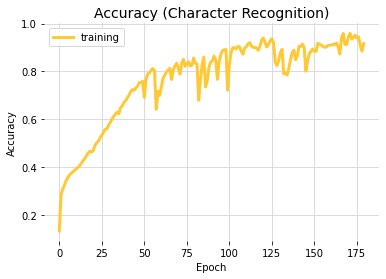

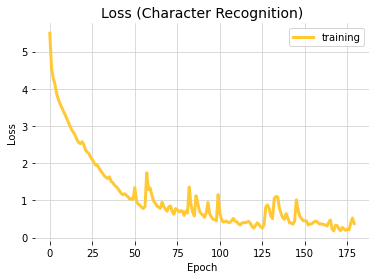

In [ ]:
colors = cycler('color',
              ['#ffc936', '#07a8d9'])
plt.rc('axes', facecolor='#FFFFFF', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle = colors)
plt.rc('grid', color='lightgray', linestyle='solid')
plt.rc('patch', edgecolor='#fafafa')
plt.rc('lines', linewidth=3)

plt.plot(history.history["accuracy"])
plt.title("Accuracy (Character Recognition)", fontsize = "14")
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend(['training'])
plt.show()

plt.plot(history.history["loss"])
plt.title("Loss (Character Recognition)", fontsize = "14")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.legend(['training'])
plt.show();

In [ ]:
model.save("drive/MyDrive/script-generation-sample/script-generation-model-with-punctuation.h5", save_format='h5')

In [ ]:
model.save_weights("drive/MyDrive/script-generation-sample/script-generation-model-weights-with-punctuation.h5", save_format='h5')

In [ ]:
saved_model = Sequential()
saved_model.add(Embedding(vocab_size, 50, input_length=x.shape[1]))
saved_model.add(LSTM(256))
saved_model.add(Dense(128, activation='relu'))
saved_model.add(Dense(vocab_size, activation='softmax'))
saved_model.load_weights("./drive/MyDrive/script-generation-sample/script-generation-model-weights-with-punctuation.h5")

saved_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            312950    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 6259)              807411    
Total params: 1,467,625
Trainable params: 1,467,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
saved_model = tf.keras.models.load_model("drive/MyDrive/script-generation-sample/script-generation-model-with-punctuation.h5")
saved_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            312950    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 6259)              807411    
Total params: 1,467,625
Trainable params: 1,467,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text_seq(model, tokenizer, text_seq_length, seed_text, n_words):
  sys.stdout.write(seed_text + "\n");
  text = []
  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen = text_seq_length, truncating='pre')
    y_predict = model.predict_classes(encoded)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_predict:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word

    if predicted_word in list(punctuations.values()):
      predicted_word = list(punctuations.keys())[list(punctuations.values()).index(predicted_word)]

    text.append(predicted_word)
  return ' '.join(text)

In [ ]:
warnings.filterwarnings("ignore") 
test_text = "marge well leave it to good old Mary Bailey to finally step in and do something about that hideous genetic mutation homer mary bailey well if i was governor i d sure find better things to do with my time marge like what homer like getting"
print(generate_text_seq(saved_model, tokenizer, sequence_length, test_text, 100))
# print(generate_text_seq(saved_model, tokenizer, sequence_length, " ".join(tokens[120:170]), 100))

marge well leave it to good old Mary Bailey to finally step in and do something about that hideous genetic mutation homer mary bailey well if i was governor i d sure find better things to do with my time marge like what homer like getting
disappointed to say by my mother , buy ran his alley . 
 lenny leonard : keep everyone here real optimistic literature celebrities ? ( cute ) oh , as it ' s so strong at us out from now . i don ' t think it ' s given me a beer . 
 
 
 larry : oh , duff lovers ! does anyone in the only dangerous brunch spectacular . 
 
 
 smitty : you know that , ain ' t that smile . 
 
 
 mrs . powers : ( suddenly nervous ) you
